# 毕业论文`GRAD`
## 要素柱状图

---
*@author: Evan*\
*@date: 2023-12-28*

In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = xr.open_dataset('D:/data/Graduation/OBS/ERA5/monthly.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 51, latitude: 41, time: 108)
Coordinates:
  * longitude  (longitude) float32 111.0 111.1 111.2 111.3 ... 115.8 115.9 116.0
  * latitude   (latitude) float32 25.0 24.9 24.8 24.7 ... 21.3 21.2 21.1 21.0
  * time       (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2022-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    ssrd       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-29 06:22:38 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [4]:
vars = list(ds.data_vars)
dts = {}
for var in vars:
    dts[var] = ds[var][:,:,:]

In [5]:
lon1d = ds.longitude
lat1d = ds.latitude
lon, lat = np.meshgrid(lon1d, lat1d,)

shp = gpd.read_file(shp_files['PRD_merge_adm'])
mask = polygon_to_mask(shp.geometry[0], lon, lat)
mask_da = xr.DataArray(mask, dims=('latitude', 'longitude'))

mk = {}
for var in vars:
    mk[var] = dts[var].where(mask_da)

In [7]:
dtime = ds.time

mks = {}
avg = {}
for var in vars:
    mks[f'{var}_summer'] = mk[var].sel(time=dtime.dt.month.isin([6,7,8])).resample(time='Y').mean()
    mks[f'{var}_autumn'] = mk[var].sel(time=dtime.dt.month.isin([9,10,11])).resample(time='Y').mean()
    for season in ['summer','autumn']:
        avg[f'{var}_{season}'] = np.nanmean(mks[f'{var}_{season}'],axis=(1,2))

In [11]:
slope = {}
intercept = {}
r_value = {}
p_value = {}
std_err = {}
for var in vars:
    for season in ['summer','autumn']:
        slope[f'{var}_{season}'], intercept[f'{var}_{season}'],\
        r_value[f'{var}_{season}'], p_value[f'{var}_{season}'],\
        std_err[f'{var}_{season}'] = \
        stats.linregress(range(9),avg[f'{var}_{season}'])

In [21]:
var = 'd2m'
print(slope[f'{var}_summer'])
print(slope[f'{var}_autumn'])

0.0004725138346354167
-0.13563435872395835


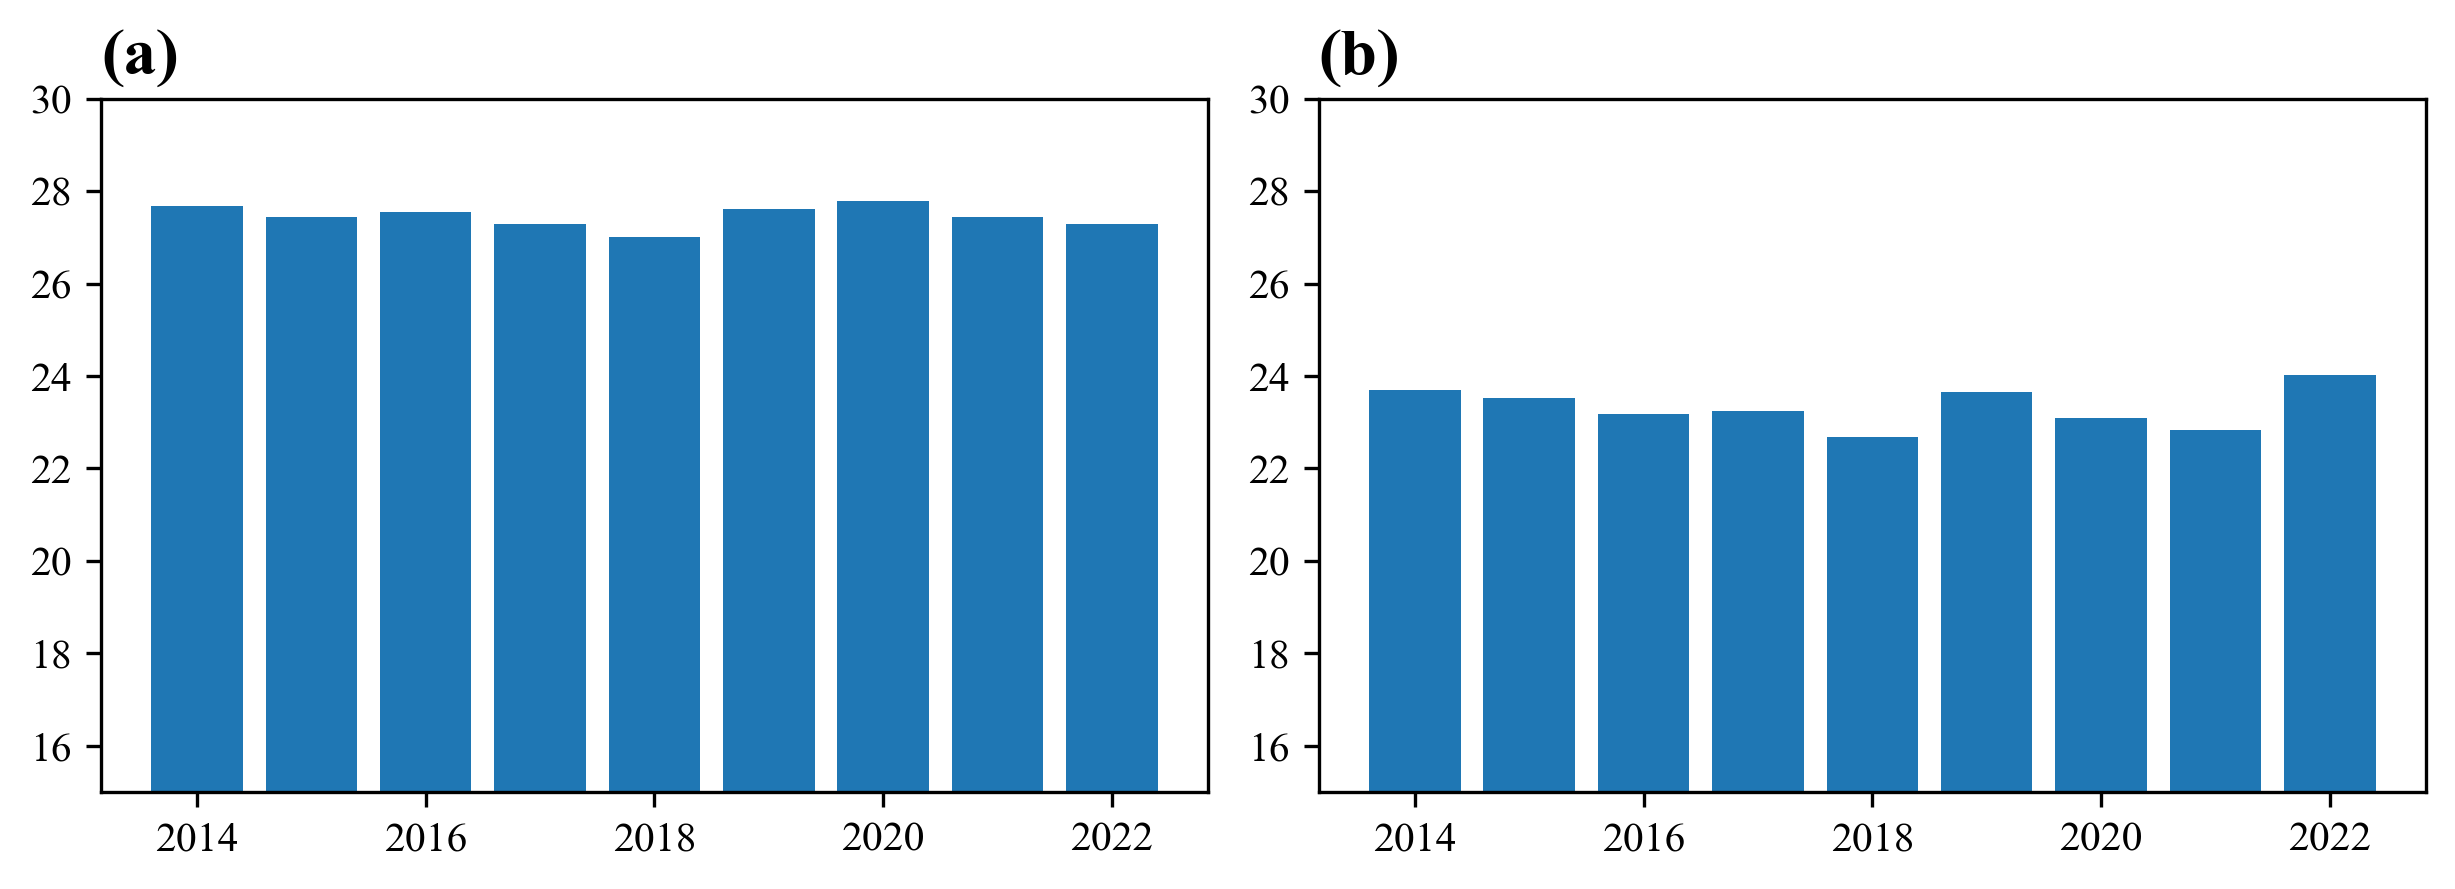

In [16]:
fig = plt.figure(figsize=(10, 3),dpi=300)
ax = fig.subplots(1,2)

tstep = np.arange(0,9)
ax[0].bar(tstep,avg['t2m_summer']-273.15)
ax[1].bar(tstep,avg['t2m_autumn']-273.15)


for i in range(2):
    ax[i].set_xticks(np.arange(0,9,2))
    ax[i].set_xticklabels(np.arange(2014,2023,2))
    ax[i].set_ylim(15,30)

titledict = dict(
    fontsize=16,
    fontweight='bold',
    loc='left'
)
ax[0].set_title('(a)',**titledict)
ax[1].set_title('(b)',**titledict)

plt.subplots_adjust(wspace=0.1)
plt.show()

In [39]:
np.nanmean(mks['t2m_autumn']-273.15,axis=(1,2))

array([23.704014, 23.520721, 23.1709  , 23.250866, 22.687817, 23.65868 ,
       23.102024, 22.829226, 24.023737, 26.386133], dtype=float32)

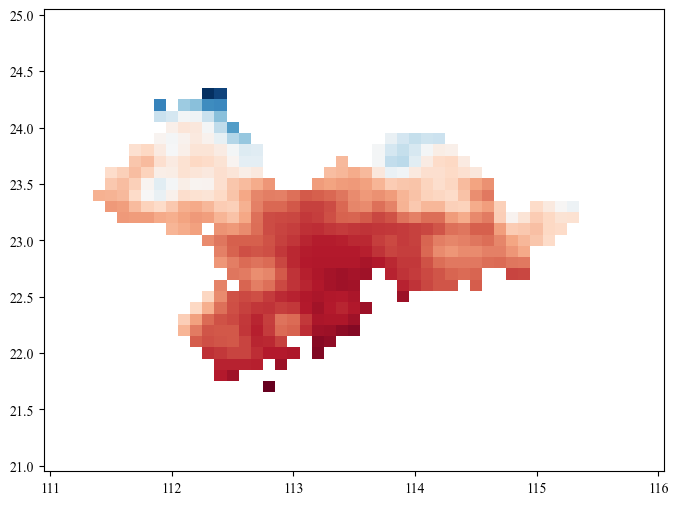

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots(1,1)
# ax.pcolormesh(lon,lat,mk['t2m'][0,:,:],cmap='RdBu_r')
ax.pcolormesh(lon,lat,te,cmap='RdBu_r')
plt.show()